# Chapter 06 
 Machine Learning for Business Analytics<br>
Concepts, Techniques, and Applications in Python<br>
by Galit Shmueli, Peter C. Bruce, Peter Gedeck, Nitin R. Patel

Publisher: Wiley; 2nd edition (2024) <br>
<!-- ISBN-13: 978-3031075650 -->

(c) 2024 Galit Shmueli, Peter C. Bruce, Peter Gedeck, Nitin R. Patel

The code needs to be executed in sequence.

Python packages and Python itself change over time. This can cause warnings or errors.
"Warnings" are for information only and can usually be ignored.
"Errors" will stop execution and need to be fixed in order to get results.

If you come across an issue with the code, please follow these steps

- Check the repository (https://gedeck.github.io/sdsa-code-solutions/) to see if the code has been upgraded. This might solve the problem.
- Report the problem using the issue tracker at https://github.com/gedeck/sdsa-code-solutions/issues
- Paste the error message into Google and see if someone else already found a solution

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LassoCV, RidgeCV, BayesianRidge
from mlxtend.feature_selection import ExhaustiveFeatureSelector, SequentialFeatureSelector
import statsmodels.formula.api as sm
import matplotlib.pylab as plt
import mlba
%matplotlib inline

In [3]:
# reduce data frame to the top 1000 rows and select columns for regression analysis
car_df = mlba.load_data('ToyotaCorolla.csv')
car_df = car_df.iloc[0:1000]

predictors = ['Age_08_04', 'KM', 'Fuel_Type', 'HP', 'Met_Color', 'Automatic', 'CC',
              'Doors', 'Quarterly_Tax', 'Weight']
outcome = 'Price'

# partition data
X = pd.get_dummies(car_df[predictors], drop_first=True)
y = car_df[outcome]
train_X, holdout_X, train_y, holdout_y = train_test_split(X, y, test_size=0.4,
                                                    random_state=1)

car_lm = LinearRegression()
car_lm.fit(train_X, train_y)

# print coefficients
print(pd.DataFrame({'Predictor': X.columns, 'coefficient': car_lm.coef_}))

# print performance measures (training data)
mlba.regressionSummary(y_true=train_y, y_pred=car_lm.predict(train_X))

           Predictor  coefficient
0          Age_08_04  -140.748761
1                 KM    -0.017840
2                 HP    36.103419
3          Met_Color    84.281830
4          Automatic   416.781954
5                 CC     0.017737
6              Doors   -50.657863
7      Quarterly_Tax    13.625325
8             Weight    13.038711
9   Fuel_Type_Diesel  1066.464681
10  Fuel_Type_Petrol  2310.249543

Regression statistics

Mean Error (ME) : -0.0000
Root Mean Squared Error (RMSE) : 1400.5823
Mean Absolute Error (MAE) : 1046.9072
Mean Percentage Error (MPE) : -1.0223
Mean Absolute Percentage Error (MAPE) : 9.2994


In [4]:
# Use predict() to make predictions on a new set
car_lm_pred = car_lm.predict(holdout_X)

result = pd.DataFrame({'Predicted': car_lm_pred, 'Actual': holdout_y,
                       'Residual': holdout_y - car_lm_pred})
print(result.head(20))

# print performance measures (holdout data)
mlba.regressionSummary(y_true=holdout_y, y_pred=car_lm_pred)

        Predicted  Actual     Residual
507  10607.333940   11500   892.666060
818   9272.705792    8950  -322.705792
452  10617.947808   11450   832.052192
368  13600.396275   11450 -2150.396275
242  12396.694660   11950  -446.694660
929   9496.498212    9995   498.501788
262  12480.063217   13500  1019.936783
810   8834.146068    7950  -884.146068
318  12183.361282    9900 -2283.361282
49   19206.965683   21950  2743.034317
446  10987.498309   11950   962.501691
142  18501.527375   19950  1448.472625
968   9914.690947    9950    35.309053
345  13827.299932   14950  1122.700068
971   7966.732543   10495  2528.267457
133  17185.242041   15950 -1235.242041
104  19952.658062   19450  -502.658062
6    16570.609280   16900   329.390720
600  13739.409113   11250 -2489.409113
496  11267.513740   11750   482.486260

Regression statistics

Mean Error (ME) : 103.6803
Root Mean Squared Error (RMSE) : 1312.8523
Mean Absolute Error (MAE) : 1017.5972
Mean Percentage Error (MPE) : -0.2633
Mean Absolu

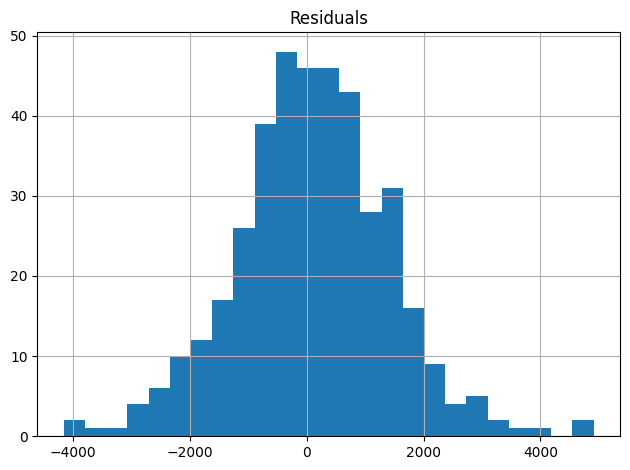

In [5]:
car_lm_pred = car_lm.predict(holdout_X)
all_residuals = holdout_y - car_lm_pred

pd.DataFrame({'Residuals': all_residuals}).hist(bins=25)
plt.tight_layout()
plt.show()

In [6]:
# Determine the percentage of datapoints with a residual
# in [-1406, 1406] = approx. 75\% of the data
print(len(all_residuals[(all_residuals > -1406) & (all_residuals < 1406)]) /
len(all_residuals))

0.7425


In [7]:
from sklearn.model_selection import cross_validate

model = LinearRegression()

scoring = {'neg_RMSE': 'neg_root_mean_squared_error',
            'neg_MAE': 'neg_mean_absolute_error'}
scores = cross_validate(model, X, y, cv=5, scoring=scoring)

print(f"CV-RMSE = {- scores['test_neg_RMSE'].mean():.2f}")
print(f"CV-MAE = {- scores['test_neg_MAE'].mean():.2f}")

CV-RMSE = 2008.43
CV-MAE = 1566.42


In [8]:
cv_results = {'RMSE': - scores['test_neg_RMSE'].mean(),
              'MAE': - scores['test_neg_MAE'].mean()}

In [9]:
model = LinearRegression()
efs = ExhaustiveFeatureSelector(model,
            min_features=1, max_features=11,
            cv=5, scoring='neg_root_mean_squared_error',
            print_progress=False, n_jobs=4)
efs = efs.fit(X, y)

print(f'Best score: {- efs.best_score_:.2f}')
print(f'Best subset (indices): {efs.best_idx_}')
print(f'Best subset (corresponding names):\n{efs.best_feature_names_}')

Best score: 1886.69
Best subset (indices): (0, 1, 2, 7, 8, 10)
Best subset (corresponding names):
('Age_08_04', 'KM', 'HP', 'Quarterly_Tax', 'Weight', 'Fuel_Type_Petrol')


2047
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220,

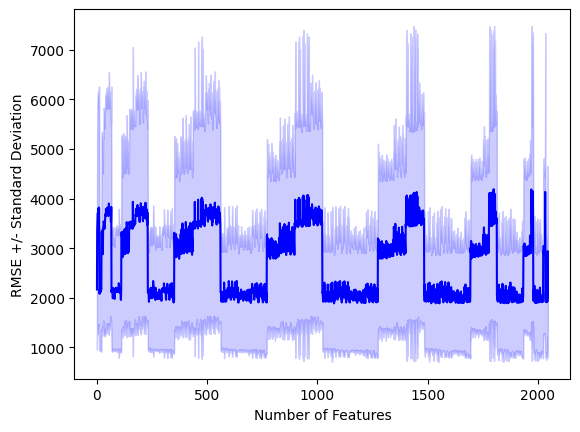

In [10]:
import matplotlib.pyplot as plt

metric_dict = efs.get_metric_dict()
print(len(metric_dict))

fig = plt.figure()
k_feat = sorted(metric_dict.keys())
avg = [-metric_dict[k]['avg_score'] for k in k_feat]
print(k_feat)

upper, lower = [], []
for k in k_feat:
    upper.append(-metric_dict[k]['avg_score'] +
                metric_dict[k]['std_dev'])
    lower.append(-metric_dict[k]['avg_score'] -
                metric_dict[k]['std_dev'])

plt.fill_between(k_feat,
                upper,
                lower,
                alpha=0.2,
                color='blue',
                lw=1)

plt.plot(k_feat, avg, color='blue') #, marker='o')
plt.ylabel('RMSE +/- Standard Deviation')
plt.xlabel('Number of Features')
feature_min = len(metric_dict[k_feat[0]]['feature_idx'])
feature_max = len(metric_dict[k_feat[-1]]['feature_idx'])
# plt.xticks(k_feat,
#            [str(metric_dict[k]['feature_names']) for k in k_feat],
#            rotation=90)
plt.show()
%matplotlib inline

In [11]:
important_features = {}
for v in efs.subsets_.values():
    n = len(v['feature_names'])
    if n not in important_features:
        important_features[n] = v
    elif v['avg_score'] > important_features[len(v['feature_names'])]['avg_score']:
        important_features[n] = v
for k, v in important_features.items():
    print(f'{k}, RMSE: {- v["avg_score"]:.2f}, Features: {v["feature_names"]}')

1, RMSE: 2167.32, Features: ('Age_08_04',)
2, RMSE: 2079.03, Features: ('Age_08_04', 'HP')
3, RMSE: 1956.46, Features: ('Age_08_04', 'Weight', 'Fuel_Type_Petrol')
4, RMSE: 1903.40, Features: ('Age_08_04', 'Quarterly_Tax', 'Weight', 'Fuel_Type_Petrol')
5, RMSE: 1894.54, Features: ('Age_08_04', 'HP', 'Quarterly_Tax', 'Weight', 'Fuel_Type_Petrol')
6, RMSE: 1886.69, Features: ('Age_08_04', 'KM', 'HP', 'Quarterly_Tax', 'Weight', 'Fuel_Type_Petrol')
7, RMSE: 1887.45, Features: ('Age_08_04', 'KM', 'HP', 'Quarterly_Tax', 'Weight', 'Fuel_Type_Diesel', 'Fuel_Type_Petrol')
8, RMSE: 1889.41, Features: ('Age_08_04', 'KM', 'HP', 'Automatic', 'Quarterly_Tax', 'Weight', 'Fuel_Type_Diesel', 'Fuel_Type_Petrol')
9, RMSE: 1892.27, Features: ('Age_08_04', 'KM', 'HP', 'Met_Color', 'Automatic', 'Quarterly_Tax', 'Weight', 'Fuel_Type_Diesel', 'Fuel_Type_Petrol')
10, RMSE: 1910.09, Features: ('Age_08_04', 'KM', 'HP', 'Met_Color', 'Automatic', 'Doors', 'Quarterly_Tax', 'Weight', 'Fuel_Type_Diesel', 'Fuel_Type_Pe

In [12]:
sfs_backward = SequentialFeatureSelector(model,
            k_features=(1, 11),
            forward=False, floating=False,
            cv=5, scoring='neg_root_mean_squared_error',
            n_jobs=-1)
sfs_backward = sfs_backward.fit(X, y)

best_subset = sfs_backward.subsets_[1]
for v in sfs_backward.subsets_.values():
    if v['avg_score'] > best_subset['avg_score']:
        best_subset = v

print(f"Best accuracy score: {- best_subset['avg_score']:.2f}")
print(f"Best subset (indices): {best_subset['feature_idx']}")
print(f"Best subset (corresponding names):\n{best_subset['feature_names']}")

/Users/petergedeck/git/Wiley-MLBA-Python-2e/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


Best accuracy score: 1886.69
Best subset (indices): (0, 1, 2, 7, 8, 10)
Best subset (corresponding names):
('Age_08_04', 'KM', 'HP', 'Quarterly_Tax', 'Weight', 'Fuel_Type_Petrol')


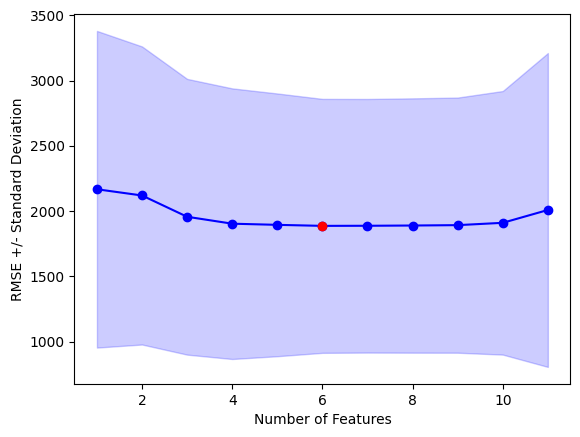

In [13]:
metric_dict = sfs_backward.get_metric_dict()

fig = plt.figure()
k_feat = sorted(metric_dict)
avg = [-metric_dict[k]['avg_score'] for k in k_feat]
best_idx = np.argmin(avg)

upper, lower = [], []
for k in k_feat:
    upper.append(-metric_dict[k]['avg_score'] + metric_dict[k]['std_dev'])
    lower.append(-metric_dict[k]['avg_score'] - metric_dict[k]['std_dev'])

plt.fill_between(k_feat, upper, lower, alpha=0.2, color='blue', lw=1)
plt.plot(k_feat, avg, color='blue', marker='o')
plt.plot(k_feat[best_idx], avg[best_idx], color='red', marker='o')
plt.ylabel('RMSE +/- Standard Deviation')
plt.xlabel('Number of Features')
plt.show()

In [14]:
sfs_forward = SequentialFeatureSelector(model,
            k_features=(1, 11),
            forward=False, floating=False,
            cv=5, scoring='neg_root_mean_squared_error',
            n_jobs=-1)
sfs_forward = sfs_forward.fit(X, y)

best_subset = sfs_forward.subsets_[1]
for v in sfs_forward.subsets_.values():
    if v['avg_score'] > best_subset['avg_score']:
        best_subset = v

print(f"Best accuracy score: {- best_subset['avg_score']:.2f}")
print(f"Best subset (indices): {best_subset['feature_idx']}")
print(f"Best subset (corresponding names):\n{best_subset['feature_names']}")

/Users/petergedeck/git/Wiley-MLBA-Python-2e/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


Best accuracy score: 1886.69
Best subset (indices): (0, 1, 2, 7, 8, 10)
Best subset (corresponding names):
('Age_08_04', 'KM', 'HP', 'Quarterly_Tax', 'Weight', 'Fuel_Type_Petrol')


In [15]:
sfs_stepwise = SequentialFeatureSelector(model,
            k_features=(1, 11),
            forward=True, floating=True,
            cv=5, scoring='neg_root_mean_squared_error',
            n_jobs=-1)

sfs_stepwise = sfs_stepwise.fit(X, y)

best_subset = sfs_stepwise.subsets_[1]
for v in sfs_stepwise.subsets_.values():
    if v['avg_score'] > best_subset['avg_score']:
        best_subset = v

print(f"Best accuracy score: {- best_subset['avg_score']:.2f}")
print(f"Best subset (indices): {best_subset['feature_idx']}")
print(f"Best subset (corresponding names):\n{best_subset['feature_names']}")

Best accuracy score: 1886.69
Best subset (indices): (0, 1, 2, 7, 8, 10)
Best subset (corresponding names):
('Age_08_04', 'KM', 'HP', 'Quarterly_Tax', 'Weight', 'Fuel_Type_Petrol')


 Lasso model

In [16]:
lasso_cv = Pipeline([
    ['normalize', StandardScaler()],
    ['model', LassoCV(cv=5, alphas=10**(np.linspace(-1, 5, 50)))],
])
lasso_cv.fit(train_X, train_y)
print(f"Lasso-CV chosen regularization: {lasso_cv['model'].alpha_:.3f}")
print(f"Coefficients: {lasso_cv['model'].coef_.round(3)}")
mlba.regressionSummary(y_true=holdout_y, y_pred=lasso_cv.predict(holdout_X))

Lasso-CV chosen regularization: 49.417
Coefficients: [-2345.28   -638.45    508.429     0.       47.189     0.       -0.
   319.629   760.803    -0.      210.304]

Regression statistics

Mean Error (ME) : 131.0072
Root Mean Squared Error (RMSE) : 1357.0463
Mean Absolute Error (MAE) : 1032.5840
Mean Percentage Error (MPE) : -0.2582
Mean Absolute Percentage Error (MAPE) : 9.1161


 Partial output

 Ridge regression

In [17]:
ridge_cv = Pipeline([
    ['normalize', StandardScaler()],
    ['model', RidgeCV(alphas=10**(np.linspace(-1, 5, 50)), store_cv_results=True)],
])
ridge_cv.fit(train_X, train_y)
print(f"Ridge-CV chosen regularization: {ridge_cv['model'].alpha_:.3f}")
print(f"Coefficients: {ridge_cv['model'].coef_.round(3)}")
mlba.regressionSummary(y_true=holdout_y, y_pred=ridge_cv.predict(holdout_X))

Ridge-CV chosen regularization: 49.417
Coefficients: [-2104.535  -760.425   518.263    50.137    77.749    28.734    -9.311
   451.961   803.166    92.901   378.559]

Regression statistics

Mean Error (ME) : 120.4566
Root Mean Squared Error (RMSE) : 1333.1797
Mean Absolute Error (MAE) : 1026.3997
Mean Percentage Error (MPE) : -0.4725
Mean Absolute Percentage Error (MAPE) : 8.9891


 Partial output

 
Note that we don't specify the cross-validation folds for ridge regression. This is due 
to the fact that `RidgeCV` has an efficient and fast implementation that uses leave-one-out
cross-validation by default. 

 Ridge regression

In [18]:
bayesianRidge = Pipeline([
    ['normalize', StandardScaler()],
    ['model', BayesianRidge()],
])
bayesianRidge.fit(train_X, train_y)
print(f"Coefficients: {ridge_cv['model'].coef_.round(3)}")
mlba.regressionSummary(y_true=holdout_y, y_pred=ridge_cv.predict(holdout_X))

Coefficients: [-2104.535  -760.425   518.263    50.137    77.749    28.734    -9.311
   451.961   803.166    92.901   378.559]

Regression statistics

Mean Error (ME) : 120.4566
Root Mean Squared Error (RMSE) : 1333.1797
Mean Absolute Error (MAE) : 1026.3997
Mean Percentage Error (MPE) : -0.4725
Mean Absolute Percentage Error (MAPE) : 8.9891


 Partial output

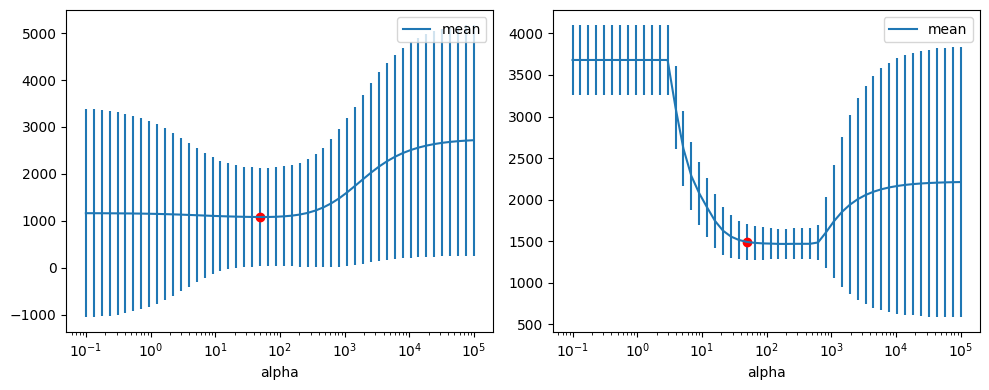

In [19]:
def plotRegularizationPath(ax, pipeline):
    model = pipeline['model']
    best_alpha = model.alpha_
    if isinstance(model, RidgeCV):
        df = pd.DataFrame({
            'alpha': model.alphas,
            'mean': np.sqrt(model.cv_results_).mean(axis=0),
            'std': np.sqrt(model.cv_results_).std(axis=0),
        })
    else:
        df = pd.DataFrame({
            'alpha': model.alphas,
            'mean': np.sqrt(model.mse_path_).mean(axis=1),
            'std': np.sqrt(model.mse_path_).std(axis=1),
        })
    best_score = df['mean'][df['alpha'] == best_alpha]
    df.plot(x='alpha', y='mean', yerr='std', logx=True, ax=ax)
    ax.plot(model.alpha_, best_score, 'ro')

fig, axes = plt.subplots(ncols=2, figsize=(10, 4))
plotRegularizationPath(axes[0], ridge_cv)
plotRegularizationPath(axes[1], lasso_cv)
plt.tight_layout()
plt.show()

In [20]:
from sklearn.pipeline import make_pipeline

efs_model = make_pipeline(efs, LinearRegression())
efs_model.fit(train_X, train_y)

sfs_stepwise_model = make_pipeline(sfs_stepwise, LinearRegression())
sfs_stepwise_model.fit(train_X, train_y)

def metrics(model, train_X, train_y, holdout_X, holdout_y):
    scoring = {'neg_RMSE': 'neg_root_mean_squared_error',
            'neg_MAE': 'neg_mean_absolute_error'}
    np.random.seed(123)
    scores = cross_validate(model,
         pd.concat([train_X, holdout_X]),
         pd.concat([train_y, holdout_y]), cv=5, scoring=scoring)

    train_pred = model.predict(train_X)
    holdout_pred = model.predict(holdout_X)
    return {
        'CV_RMSE': - scores['test_neg_RMSE'].mean(),
        'CV_MAE': - scores['test_neg_MAE'].mean(),
        'train_RMSE': np.sqrt(np.mean((train_y - train_pred)**2)),
        'train_MAE': np.mean(np.abs(train_y - train_pred)),
        'holdout_RMSE': np.sqrt(np.mean((holdout_y - holdout_pred)**2)),
        'holdout_MAE': np.mean(np.abs(holdout_y - holdout_pred)),
    }
pd.DataFrame({
    'Full': metrics(car_lm, train_X, train_y, holdout_X, holdout_y),
    'Exhaustive': metrics(efs_model, train_X, train_y, holdout_X, holdout_y),
    'Stepwise': metrics(sfs_stepwise_model, train_X, train_y, holdout_X, holdout_y),
    'Ridge': metrics(ridge_cv, train_X, train_y, holdout_X, holdout_y),
    'Lasso': metrics(lasso_cv, train_X, train_y, holdout_X, holdout_y),
}).transpose().round(0)

,CV_RMSE,CV_MAE,train_RMSE,train_MAE,holdout_RMSE,holdout_MAE
Full,1813.0,1080.0,1401.0,1047.0,1313.0,1018.0
Exhaustive,1830.0,1086.0,1427.0,1071.0,1356.0,1041.0
Stepwise,1830.0,1086.0,1427.0,1071.0,1356.0,1041.0
Ridge,1711.0,1081.0,1420.0,1046.0,1333.0,1026.0
Lasso,1828.0,1089.0,1419.0,1055.0,1357.0,1033.0


In [21]:
# run a linear regression of Price on the remaining 11 predictors in the training set
train_df = train_X.join(train_y)

predictors = train_X.columns
formula = 'Price ~ ' + ' + '.join(predictors)

car_lm = sm.ols(formula=formula, data=train_df).fit()
car_lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.856
Model:                            OLS   Adj. R-squared:                  0.854
Method:                 Least Squares   F-statistic:                     319.0
Date:                Mon, 04 Nov 2024   Prob (F-statistic):          1.73e-239
Time:                        17:24:10   Log-Likelihood:                -5198.1
No. Observations:                 600   AIC:                         1.042e+04
Df Residuals:                     588   BIC:                         1.047e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                -1319.3544   1728.427     -0.763      0.446   -4713.997    2075.288
Fuel_Type_Diesel[T.True]  1066.4647    527.285      2.023      0.044      30.872    2102.057
Fuel_Type_Petrol[T.True]  2310.2495    521.045      4.434      0.000    1286.914    3333.585
Age_08_04                 -140.7488      5.142    -27.374      0.000    -150.847    -130.650
KM                          -0.0178      0.002     -7.286      0.000      -0.023      -0.013
HP                          36.1034      5.321      6.785      0.000      25.653      46.554
Met_Color                   84.2818    127.005      0.664      0.507    -165.158     333.721
Automatic                  416.7820    259.794      1.604      0.109     -93.454     927.018
CC                           0.0177      0.099      0.179      0.858      -0.177       0.213
Doors                      -50.6579     65.187     -0.777      0.437    -178.686      77.371
Quarterly_Tax               13.6253      2.518      5.411      0.000       8.680      18.571
Weight                      13.0387      1.602      8.140      0.000       9.893      16.185
==============================================================================
Omnibus:                       62.422   Durbin-Watson:                   1.899
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              366.046
Skew:                           0.186   Prob(JB):                     3.27e-80
Kurtosis:                       6.808   Cond. No.                     2.20e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.2e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""